In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mphelper import ProcessWrapPool
from Bio import SeqIO
from matplotlib.colors import LinearSegmentedColormap
import itertools
from biodata.bed import BEDXReader
from genomictools import GenomicCollection
import sys
from pathlib import Path

In [2]:
matplotlib.font_manager.fontManager.addfont(f"{Path.cwd().parent}/font/Arial.ttf")
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [3]:
sys.path.append(str(Path.cwd().parent))
import utils

In [4]:
PROJECT_DIR_d = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/PROcap/"
PROJECT_DIR_r = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/resources/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/TRE_directionality/output/"

# Generate sequence matrix

In [5]:
s = "C1"
ps = ["divergent", "unidirectional"]
ds = ["distal", "proximal"]
gs = [f"{p}_{d}" for p, d in itertools.product(ps, ds)]

In [6]:
# 0-based

inputfile = f"{PROJECT_DIR_r}genomes/human/GRCh38_no_alt_analysis_set_GCA_000001405.15.fasta"
with open(inputfile, "r") as f:
	fdict = SeqIO.to_dict(SeqIO.parse(f, "fasta"))

In [7]:
def get_binary_sequence_matrix(inputfile, fdict):
	"""
	Get sequence content for a given peak file (G/C:1; T/A:0).  
	If the forward strand has more reads, keep the original sequence; 
	Otherwise, use the reverse complementary sequence.
	"""
	
	results = []
	all_regions = BEDXReader.read_all(GenomicCollection, inputfile, strandfield="f7")
	index = [f"{r.chrom}_{r.chromStart}_{r.chromEnd}" for r in all_regions]
	for r in all_regions:
		seq = fdict[r.chrom][r.chromStart:r.chromEnd].seq
		if r.stranded_genomic_pos.strand == "-":
			seq = seq.reverse_complement()
		seq2 = [0 if i in ["A", "a", "T", "t"] else 1 for i in seq]
		results.append(seq2)
	df = pd.DataFrame(results, index=index)
	return df

In [8]:
df_heatmaps = {}
for g in gs:
	inputfile = f"{PROJECT_DIR_d}bed_plot/{s}_{g}.bed"
	df_heatmaps[g] = get_binary_sequence_matrix(inputfile, fdict)

# Generate heatmaps

## Settings

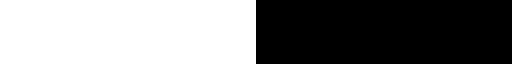

In [9]:
# Make a discrete cmap

colors = ("#ffffff", "#000000")
cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))
cmap

## Generate heatmaps

In [10]:
def generate_heatmap(d, ps, df_heatmaps, sort_file, ylims, cbar_ticks, cmap, outputfile, test, xlabel="Distance (bp)"):
	fig, axes = plt.subplots(1, len(ps), figsize=(6, 3))
	labelpad = 2
	wspace = 0.15
	
	for p in ps:
		col = ps.index(p)
		ax = axes[col]

		if col == 1:
			cbar = True
			cbar_ax = fig.add_axes([0.92, 0.7, 0.02, 0.1])
		else:
			cbar = False
			cbar_ax = None	
		cbar_kws = {"ticks": cbar_ticks}
		
		utils.generate_feature_heatmap(df_heatmaps[(f"{p}_{d}")], ylims, cmap, cbar, cbar_ax, cbar_kws, ax, sort_file, test)
		
		if col == len(ps)-1:
			cbar_ax.set_yticklabels(["A/T", "C/G"])
			cbar_ax.spines["outline"].set(visible=True, lw=1, edgecolor="black")

		ax.set_title(p.capitalize(), fontsize=bfontsize, pad=labelpad+5)

		ax.set_ylabel("")
		
		xtick_list = [0, 250, 500]
		xticklabel_list = ["-250", "0", "250"]
		ax.set_xlim([0, 500])
		ax.set_xticks(xtick_list)
		ax.set_xticklabels(xticklabel_list)
		ax.set_xlabel(xlabel, fontsize=bfontsize)
		
		ax.tick_params(labelsize=sfontsize, pad=labelpad)

	fig.subplots_adjust(wspace=wspace)
	plt.savefig(outputfile, bbox_inches="tight", transparent=True)

In [11]:
pwpool = ProcessWrapPool(len(ds))

# test = True
test = False
ylims = [0,1]
cbar_ticks = [0.25, 0.75]
sort_file = f"{PROJECT_DIR_o}labels/{s}_distance_to_center.json"
for d in ds:
	folder = "figures/" if d == "distal" else "other_figures/"
	outputfile = f"{PROJECT_DIR_o}{folder}Fig2a.pdf"
	pwpool.run(generate_heatmap, args=[d, ps, df_heatmaps, sort_file, ylims, cbar_ticks, cmap, outputfile, test])

In [15]:
len(pwpool.finished_tasks)

2

In [16]:
pwpool.close()